In [ ]:
import nltk
from nltk.corpus import gutenberg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, SimpleRNN, Bidirectional
import numpy as np
nltk.download('gutenberg')
import pandas
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
url = 'https://drive.google.com/uc?id=1tEWHdL7AIycQkkb5MlRINhaJAwTL2f2-'
df = pandas.read_csv(url)
df.head()

,id,text
0,1190735819,recurso extraordinário com agravo 1.126.769 ri...
1,858435100,a c ó r d ã o (3 turma) gmmgd/ls/dsc agravo. a...
2,226722772,poder judiciário tribunal de justiça do estad...
3,226806677,ed nº 70055698377 (nº cnj: 029446471.2013.8.2...
4,227181039,poder judiciário tribunal de justiça estado ...


In [ ]:
import unicodedata
from nltk.corpus import stopwords
from nltk.corpus import wordnet

def remove_acentuacao(palavra):
  nfkd = unicodedata.normalize('NFKD', palavra)
  palavraSemAcento = "".join([c for c in nfkd if not unicodedata.combining(c)])
  return palavraSemAcento

In [ ]:
from gensim.utils import simple_preprocess

for text in df['text']:
  words = nltk.word_tokenize(text)
  words_processed = [remove_acentuacao(word) for word in words if
                     word.isalpha() or word.isspace() or (len(word) >= 2 and len(word) < 15)
  ]
  df['text_mod'] = df['text'].replace(text, ' '.join(words_processed))

In [ ]:
def tokenize(text):
    return simple_preprocess(text, deacc=True)

df['tokens'] = df['text_mod'].apply(tokenize)
df.head()

,id,text,text_mod,tokens
0,1190735819,recurso extraordinário com agravo 1.126.769 ri...,recurso extraordinário com agravo 1.126.769 ri...,"[recurso, extraordinario, com, agravo, rio, de..."
1,858435100,a c ó r d ã o (3 turma) gmmgd/ls/dsc agravo. a...,a c ó r d ã o (3 turma) gmmgd/ls/dsc agravo. a...,"[turma, gmmgd, ls, dsc, agravo, agravo, de, in..."
2,226722772,poder judiciário tribunal de justiça do estad...,poder judiciário tribunal de justiça do estad...,"[poder, judiciario, tribunal, de, justica, do,..."
3,226806677,ed nº 70055698377 (nº cnj: 029446471.2013.8.2...,ed nº 70055698377 (nº cnj: 029446471.2013.8.2...,"[ed, nº, nº, cnj, civel, apelacao, reexame, ne..."
4,227181039,poder judiciário tribunal de justiça estado ...,poder judiciário tribunal de justiça estado ...,"[poder, judiciario, tribunal, de, justica, est..."


In [ ]:
from gensim.models import Word2Vec

num_features = 300
min_word_count = 3
num_workers = 2
window_size = 6
subsampling = 1e-3

model = Word2Vec(df['tokens'], vector_size=num_features, window=window_size, min_count=min_word_count, workers=num_workers, sample=subsampling, sg=1, epochs=10)

In [ ]:
word_vectors = model.wv

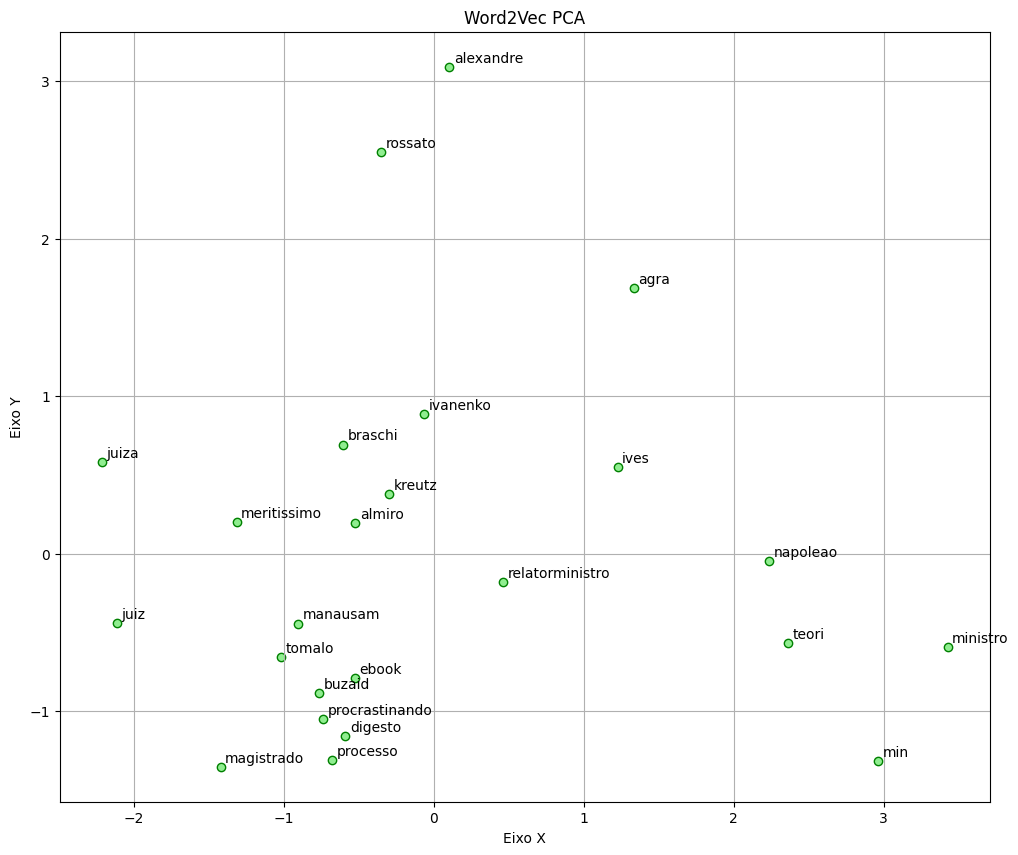

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

search_terms = ['alexandre', 'juiz', 'processo', 'ministro']
similar_words = {
    search_term: [item[0] for item in word_vectors.most_similar(search_term, topn=5)]
    for search_term in search_terms
}

words = sum([[search_term] + v for search_term, v in similar_words.items()], [])
wvs = word_vectors[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.03, y + 0.03),
                 xytext=(0, 0),
                 textcoords='offset points')

plt.title('Word2Vec PCA')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.grid(True)
plt.show()

In [ ]:
print(word_vectors.most_similar('juiz'))

[('magistrado', 0.5711795687675476), ('juiza', 0.5437019467353821), ('almiro', 0.46305936574935913), ('meritissimo', 0.4570893347263336), ('tomalo', 0.453488290309906), ('sateles', 0.4485974907875061), ('ulhoa', 0.44096869230270386), ('aldino', 0.4404262900352478), ('ºgrau', 0.43968474864959717), ('mmº', 0.43411147594451904)]


In [ ]:
print(word_vectors.most_similar('crime'))

[('delito', 0.7892543077468872), ('estupro', 0.6357358694076538), ('receptacao', 0.6346213817596436), ('roubo', 0.6287902593612671), ('crimes', 0.6145782470703125), ('furto', 0.608945369720459), ('tipificado', 0.6047648787498474), ('delitos', 0.6041611433029175), ('latrocinio', 0.6027435064315796), ('doloso', 0.6027330756187439)]


## Faz sentido o que o modelo retornou? Justifique. ##

Sim faz sentido, a palavra magistrado obteve a maior probabilidade, seguido de juiza, ... e assim em diante. As palavras magistrado e juiza estão no mesmo contexto e tanto magistrado, quanto juiza realmente são palavras muito próximas a palavra juíz, o que faz sentido semântico.

Algumas palavras especificas como almiro (exemplo de trecho do texto que fala dele: "rel. juiz federal almiro josé da rocha lemos") e naor (exemplo de trecho do texto que fala dele: "relator: juiz subst. 2ºgrau naor ribeiro de macedo neto") são palavras de nome próprio e por base na frequência em que a palavra juiz refere-se a almiro e naor, o modelo Word2Vec encontrou uma similaridade entre o nome dessas pessoas para a palavra juiz.

O modelo Word2Vec observa principalmente a frequência com que essas palavras ocorrem e coocorrem nos dados de treino.



Já para a palavra crime, ele encontrou altas similaridades para a palavra delito, com uma probabilidade de 78.7%, muito maior que por exemplo a palavra magistrado similar a juiz com uma taxa de 58.6%.
As demais palavras próximas a crime tem uma similaridade muito próxima também, como "roubo", "receptação", ...

## Rode as seguintes analogias: ##

Promotora está para juiz assim como promotor está para o que?

In [ ]:
resultado_analogia_1 = word_vectors.most_similar(positive=['promotor', 'juiz'], negative=['promotora'], topn=1)
print("Promotora está para juiz assim como promotor está para:", resultado_analogia_1[0][0])


Promotora está para juiz assim como promotor está para: magistrado


Acusado está para réu assim como testemunha está para o que?


In [ ]:
resultado_analogia_2 = word_vectors.most_similar(positive=['testemunha', 'reu'], negative=['acusado'], topn=3)
print("Acusado está para réu assim como testemunha está para:", resultado_analogia_2[0][0])

Acusado está para réu assim como testemunha está para: rogo


Proponha mais três analogias como essas para demonstrar que os embeddings foram bem treinados.

In [ ]:
resultado_analogia_2 = word_vectors.most_similar(positive=['stf', 'juiz'], negative=['alexandre'], topn=3)
print("Alexandre está para stf assim como juiz está para:", resultado_analogia_2[0][0])

Alexandre está para stf assim como juiz está para: supremo


In [ ]:
resultado_analogia_2 = word_vectors.most_similar(positive=['crime', 'delito'], negative=['roubo'], topn=3)
print("Roubo está para crime assim como delito está para:", resultado_analogia_2[0][0])

Roubo está para crime assim como delito está para: doloso


In [ ]:
resultado_analogia_2 = word_vectors.most_similar(positive=['culposo', 'crime'], negative=['involuntario'], topn=3)
print("Involuntario está para culposo assim como crime está para:", resultado_analogia_2[0][0])

Involuntario está para culposo assim como crime está para: delito


## Discussão dos resultados ##

O resultado foi bem satisfatório para o resultado das analogias fornecidas.
Ele usa o cálculo vetorial:
<br>

Vetor(D) ≃ Vetor(B) - Vetor(A) + Vetor(C)

<br>
<br>




### Para o primeiro exemplo ###

Para o exemplo, "promotora está para juiz assim como promotor está para: magistrado", foi feito dessa forma:

<br>

vetor(D) ≈ Vetor(juiz)− Vetor(promotora) + Vetor(promotor)

vetor(D) ≈ magistrado

<br>

No contexto de treinamento, o modelo considera como as palavras aparecem em contextos semelhantes no corpus. Se a palavra "juiz" e "promotora" aparecem frequentemente juntos, e "magistrado" é frequentememnte associado a "juiz", então "promotor" está próximo de "magistrado".

Na semântica relacional, ele considera que "depoimento" está altamente associado a "reu", semelhante a como "testemunha" está semanticamente associado a "depoimento".

<br>

### Para o segundo exemplo ###

Para o exemplo, "acusado está para réu assim como testemunha está para: depoimento", foi feito dessa forma:

<br>

vetor(D) ≈ Vetor(reu)− Vetor(acusado) + Vetor(testemunha)

vetor(D) ≈ depoimento
    
<br>

No contexto de treinamento, o modelo considera como as palavras aparecem em contextos semelhantes no corpus. Se a palavra "acusado" e "reu" aparecem frequentemente juntos, e "depoimento" é frequentememnte associado a "reu", então "acusado" está próximo de "depoimento".

Na semântica relacional, ele considera que "depoimento" está altamente associado a "reu", semelhante a como "testemunha" está semanticamente associado a "depoimento".

<br>


### Para o terceiro exemplo ###

Para o exemplo, "alexandre está para stf assim como juiz está para: supremo", foi feito dessa forma:

<br>

vetor(D) ≈ Vetor(stf)− Vetor(alexandre) + Vetor(juiz)

vetor(D) ≈ supremo

<br>

No contexto de treinamento, o modelo considera como as palavras aparecem em contextos semelhantes no corpus. Se a palavra "alexandre" e "stf" aparecem frequentemente juntos, e "supremo" é frequentememnte associado a "stf", então alexandre está próximo de "supremo".

Na semântica relacional, ele considera que "supremo" está altamente associado a "stf", semelhante a como "juiz" está semanticamente associado a "supremo".





# Geração de texto baseado em palavras similares



In [ ]:
import random

def next_word(words, used_words, pooling="mean"):
    embeddings = [word_vectors[word] for word in words if word in word_vectors]

    if not embeddings:
        return None

    if pooling == "sum":
      mean_embedding = np.sum(embeddings, axis=0)
    elif pooling == "mean":
      mean_embedding = np.mean(embeddings, axis=0)
    elif pooling == "max":
      mean_embedding = np.max(embeddings, axis=0)
    else:
      raise("Pooling não compatível")
    similar_words = word_vectors.similar_by_vector(mean_embedding, topn=3)

    return similar_words[1][0]

def gerar_texto(palavra_inicial, tamanho_maximo, window_size=3, pooling="mean"):
    texto_gerado = [palavra_inicial]
    used_words = set(texto_gerado)

    for _ in range(tamanho_maximo):
        start_idx = max(0, len(texto_gerado) - window_size)
        words = texto_gerado[start_idx:]
        proxima_palavra = next_word(words, used_words, pooling)

        if proxima_palavra:
            texto_gerado.append(proxima_palavra)
            used_words.add(proxima_palavra)
        else:
            break

    return ' '.join(texto_gerado)

In [ ]:
palavra_inicial = "juiz"
tamanho_maximo = 10
texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=3)
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=3, pooling="sum")
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=5)
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=5, pooling="sum")
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=2)
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=2, pooling="sum")
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=10)
print(texto_gerado)

texto_gerado = gerar_texto(palavra_inicial, tamanho_maximo, window_size=10, pooling="sum")
print(texto_gerado)

juiz magistrado magistrado juiz juiz magistrado magistrado juiz juiz magistrado magistrado
juiz magistrado magistrado juiz juiz magistrado magistrado juiz juiz magistrado magistrado
juiz magistrado magistrado juiz magistrado juiz juiz magistrado magistrado juiz magistrado
juiz magistrado magistrado juiz magistrado juiz juiz magistrado magistrado juiz magistrado
juiz magistrado magistrado sentenciante magistrado magistrado sentenciante magistrado magistrado sentenciante magistrado
juiz magistrado magistrado sentenciante magistrado magistrado sentenciante magistrado magistrado sentenciante magistrado
juiz magistrado magistrado juiz magistrado juiz magistrado juiz magistrado juiz magistrado
juiz magistrado magistrado juiz magistrado juiz magistrado juiz magistrado juiz magistrado


## Comentários:

O texto gerado não faz sentido semânticamente.

Quando usamos uma palavra X para trazer as palavras mais similares a ela, sempre vinha com certeza de 100% que a própria palavra X é mais proximo a ela mesma.

Para resolver esse problema, eu peguei a segunda palavra das entre as top 3 mais similares para poder construir esse texto.

Entretanto, o texto gerado ficou ruim porque se uma palavra Y é próxima de uma palavra X, então provavelmente essas palavras irão aparecer novamente no texto porque uma está muito próxima a outra, e isso não deixa muito bem gerar o texto sem muita repeticão, além de que não irá possuir muito sentido o texto gerado.

E o problema aparentemente é similar independente do tipo de pooling, se é por média ou soma dos embeddings das palavras já geradas.

Mas podemos observar de quando o tamanho da janela é menor (como para 2) ele captura algumas palavras que os outros não conseguiram capturar, independente do tamanho da janela quando ultrapassa o valor de 3.


# Geração de texto: #

In [ ]:
df = df.sample(30)
texto = ""
for i in df["text"]:
  texto += i + " "

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenize = Tokenizer()
tokenize.fit_on_texts([texto])
tokens = len(tokenize.word_index)
token_list = tokenize.texts_to_sequences([texto])[0]

In [ ]:
sequence = 40
sequencias = []
next_words = []

for i in range(len(token_list) - sequence):
    sequencias.append(token_list[i:i+sequence])
    next_words.append(token_list[i+sequence])

In [ ]:
import numpy as np
import tensorflow

x = np.array(sequencias)
y = tensorflow.keras.utils.to_categorical(next_words, num_classes=tokens+1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=tokens+1, output_dim=50, input_length=sequence))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(40))
model.add(Dense(tokens+1, activation='softmax'))
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(x, y, batch_size=128, epochs=30, verbose=2)

Epoch 1/30
500/500 - 43s - loss: 6.7153 - accuracy: 0.0664 - 43s/epoch - 87ms/step
Epoch 2/30
500/500 - 44s - loss: 6.3720 - accuracy: 0.0801 - 44s/epoch - 88ms/step
Epoch 3/30
500/500 - 46s - loss: 6.0541 - accuracy: 0.1008 - 46s/epoch - 92ms/step
Epoch 4/30
500/500 - 54s - loss: 5.7666 - accuracy: 0.1227 - 54s/epoch - 108ms/step
Epoch 5/30
500/500 - 43s - loss: 5.5007 - accuracy: 0.1398 - 43s/epoch - 87ms/step
Epoch 6/30
500/500 - 44s - loss: 5.2494 - accuracy: 0.1576 - 44s/epoch - 87ms/step
Epoch 7/30
500/500 - 48s - loss: 5.0205 - accuracy: 0.1732 - 48s/epoch - 97ms/step
Epoch 8/30
500/500 - 44s - loss: 4.8096 - accuracy: 0.1891 - 44s/epoch - 88ms/step
Epoch 9/30
500/500 - 50s - loss: 4.6156 - accuracy: 0.2042 - 50s/epoch - 100ms/step
Epoch 10/30
500/500 - 42s - loss: 4.4328 - accuracy: 0.2152 - 42s/epoch - 85ms/step
Epoch 11/30
500/500 - 42s - loss: 4.2669 - accuracy: 0.2312 - 42s/epoch - 85ms/step
Epoch 12/30
500/500 - 55s - loss: 4.1146 - accuracy: 0.2403 - 55s/epoch - 109ms/ste

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-7) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=1.0):
    generated_text = seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

        preds = model.predict(token_list, verbose=0)[0]
        predicted_index = sample(preds, temperature)

        if predicted_index == 0:
            break

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break

        if output_word and output_word.isalpha():
            generated_text += " " + output_word
        else:
            break

    return generated_text


In [ ]:
seed = "crime"
next_words = 100
generated_text = generate_text(seed, next_words, model, tokenize, max_sequence_len=40, temperature=0.2)

print("Para termperatura igual a 0.2:")
print(generated_text)
generated_text = generate_text(seed, next_words, model, tokenize, max_sequence_len=40, temperature=0.5)

print("\nPara termperatura igual a 0.5:")
print(generated_text)

generated_text = generate_text(seed, next_words, model, tokenize, max_sequence_len=40, temperature=0.7)
print("\nPara termperatura igual a 0.7:")
print(generated_text)
generated_text = generate_text(seed, next_words, model, tokenize, max_sequence_len=40, temperature=1.0)

print("\nPara termperatura igual a 1.0:")
print(generated_text)

Para termperatura igual a 0.2:
crime de forma de forma de que a desistência do recurso de revista para a antaq em vista que a parte autora a arcarem com a modificação do art

Para termperatura igual a 0.5:
crime normativo no voto do código de processo civil que a jurisprudência de um indexador de segurança impetrado no dia passivo de carreira do mercado analisada a reforma da lei nº

Para termperatura igual a 0.7:
crime da rodosul conduziu os pedidos no caso para sua filiação ao fato do príncipe é vedado ao agravo de instrumento em

Para termperatura igual a 1.0:
crime revisional julgada é esse pedido a agravante que interposto por cada nulidade é a ação de retratação por forma condenatória da instância apurada na av irí para um ação penal a perda das horas da decisão do tribunal de processo civil em esclarece a conversão de intimação pessoal da ausência de fixação de rodovias e de abastecimento


Analisando as sentenças geradas, percebe-se que o texto não segue uma estrutura gramatical correta, mas mesmo assim, ela gerou um texto melhor do que o texto gerado pelas similaridades entre as palavars do Word2Vec. Isso ocorre porque o Word2Vec não tem memória, e a LSTM simula uma memória de curto prazo onde a saída de cada neuronio vai para a própria entrada do neurônio e isso simula uma memória.


Observa-se também pelo texto gerado que faltam conectores e pontuações entre partes da frase, e por isso a frase não tem uma semântica correta que nos ajude a entrender o contexto do texto.

Os textos gerados com diferentes temperaturas mostram variações significativas em coerência.

- Com temperatura 0.2, o modelo gera uma frase relativamente clara e focada. Esse texto menciona aspectos jurídicos como "desistência do recurso de revista" e "modificação do art", sugerindo uma situação específica em que um recurso legal está sendo discutido. A estrutura é direta e os termos são usados de maneira previsível, o que resulta em um texto que é fácil de entender, mas que pode parecer repetitivo ou pouco variado, aparecem palavras repetidas nesse texto.

- Quando a temperatura é ajustada para 0.5, o modelo começa a introduzir uma maior complexidade. O texto menciona "crime normativo", "código de processo civil" e "jurisprudência", sugerindo um contexto jurídico mais amplo. A frase é mais detalhada, com referências a aspectos legais e processuais que estão sendo analisados. Embora ainda seja relativamente compreensível, há um aumento na complexidade e na variedade dos termos usados, refletindo uma combinação mais rica de conceitos e detalhes.

- Ao aumentar a temperatura para 0.7, o modelo produz um texto que é mais criativo e variado. A frase inclui termos como "rodosul", "filição ao fato do príncipe" e "agravo de instrumento", que indicam uma mistura de conceitos jurídicos e administrativos. O texto começa a mostrar uma estrutura menos previsível e mais fragmentada, com uma combinação de ideias que pode parecer desconexa. A diversidade de termos e conceitos adiciona uma camada de complexidade, mas também pode tornar a frase mais difícil de seguir.

- Com temperatura 1.0, o texto se torna o mais criativo e menos coeso. Ele mistura vários conceitos e termos de maneira que pode parecer confusa. A frase menciona "revisional julgada", "nulidade", "ação penal" e "perda das horas", entre outros termos, em um fluxo de ideias que não se conectam bem. A falta de clareza e a combinação aleatória de termos e conceitos refletem a alta aleatoriedade permitida por essa temperatura, resultando em um texto que é mais difícil de entender e parece desordenado.

Perbebe-se que a variação na temperatura afeta diretamente a coerência e a criatividade dos textos gerados. Temperaturas mais baixas resultaram em textos mais previsíveis e coerentes, enquanto temperaturas mais altas introduzem mais criatividade e variação, mas podem sacrificar a clareza e a coesão.